# AORC Download and Storm Catalog

This notebook demonstrates how to download AORC (Analysis of Record for Calibration) precipitation data and build storm catalogs for HEC-HMS gridded precipitation modeling.

**Workflow Overview**:
1. Download HUC12 watersheds as study area templates (HmsHuc)
2. Generate storm catalog from AORC data (HmsAorc)
3. Download AORC precipitation data for selected storm
4. Convert to DSS grid format for HMS

**Prerequisites**:
- Internet connection (AWS S3 and USGS web services)
- Optional dependencies: `pip install hms-commander[all]`

**Series Navigation**:
- **14a** (this notebook): AORC download and storm catalog
- **14b**: HMS grid definition and HRAP mapping
- **14c**: HMS execution and results analysis

In [1]:
# pip install hms-commander[all]

**For Development**: If working on hms-commander source code, use the `hmscmdr_local` conda environment (editable install) instead of pip install.

**Network Requirements**: This notebook requires internet access to:
- USGS WBD web services (HUC watershed boundaries)
- AWS S3 (AORC precipitation data - anonymous access)

## Setup and Imports

In [2]:
from pathlib import Path
from datetime import datetime
import warnings
import logging

# Suppress common verbose warnings but keep ERROR level visible
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Set AWS/S3 loggers to WARNING (still shows errors)
logging.getLogger('botocore').setLevel(logging.WARNING)
logging.getLogger('botocore.httpchecksum').setLevel(logging.WARNING)
logging.getLogger('s3fs').setLevel(logging.WARNING)
logging.getLogger('aiobotocore').setLevel(logging.WARNING)

# HMS Commander imports
from hms_commander import HmsHuc, HmsAorc, HmsExamples

# Create output directory for this workflow
output_dir = Path("aorc_workflow_output")
output_dir.mkdir(exist_ok=True)

print(f"Output directory: {output_dir.absolute()}")
print(f"Workflow started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Output directory: C:\GH\hms-commander\examples\aorc_workflow_output
Workflow started: 2026-01-08 13:32:24


## Phase 1: Download HUC12 Watersheds

We'll use Bald Eagle Creek watershed in Pennsylvania as our study area. HmsHuc downloads HUC boundaries from USGS web services.

In [3]:
# Study area bounds (west, south, east, north)
# Bald Eagle Creek, PA - a well-documented watershed
bounds = (-77.71, 41.01, -77.25, 41.22)

print("Study Area: Bald Eagle Creek, PA")
print(f"  West:  {bounds[0]}deg")
print(f"  South: {bounds[1]}deg")
print(f"  East:  {bounds[2]}deg")
print(f"  North: {bounds[3]}deg")
print(f"  Width:  {abs(bounds[2] - bounds[0]):.2f}deg (~{abs(bounds[2] - bounds[0]) * 85:.1f} km)")
print(f"  Height: {abs(bounds[3] - bounds[1]):.2f}deg (~{abs(bounds[3] - bounds[1]) * 111:.1f} km)")

Study Area: Bald Eagle Creek, PA
  West:  -77.71deg
  South: 41.01deg
  East:  -77.25deg
  North: 41.22deg
  Width:  0.46deg (~39.1 km)
  Height: 0.21deg (~23.3 km)


In [4]:
# Download HUC12 watersheds for study area
print("Downloading HUC12 watersheds from USGS WBD...")
watersheds = HmsHuc.get_huc12_for_bounds(bounds)

print(f"\nDownloaded {len(watersheds)} HUC12 watersheds")
print(f"Total area: {watersheds['areasqkm'].sum():.1f} km2")

2026-01-08 13:32:38 - hms_commander.HmsHuc - INFO - Downloading HUC12 watersheds for bounds: (-77.71, 41.01, -77.25, 41.22)


2026-01-08 13:32:39 - hms_commander.HmsHuc - INFO - Downloaded 23 HUC12 watersheds



Downloaded 23 HUC12 watersheds
Total area: 2150.5 km2


In [5]:
# Display watershed summary
display_cols = ['huc12', 'name', 'areasqkm']
watersheds[display_cols]

,huc12,name,areasqkm
0,020502030404,Baker Run,47.87
1,020502030405,North Fork Tangascootack Creek,49.10
2,020502030406,Tangascootack Creek,45.92
3,020502030407,Lick Run,98.74
4,020502030408,Ferney Run-West Branch Susquehanna River,66.99
5,020502030410,McElhattan Creek,53.17
6,020502030409,Queens Run,47.22
7,020502030411,Chatham Run,61.41
8,020502030412,Reeds Run-West Branch Susquehanna River,91.62
9,020502040205,Beech Creek,127.38


In [6]:
# Get HUC information
huc_info = HmsHuc.get_huc_info()
print("HUC Level Information:")
for level, info in huc_info.items():
    print(f"  {level}: {info['description']} (typical size: {info['typical_size']})")

HUC Level Information:
  huc2: Major drainage basins (typical size: >10,000 sq mi)
  huc4: Large watershed groups (typical size: 1,000-10,000 sq mi)
  huc6: Medium watersheds (typical size: 100-1,000 sq mi)
  huc8: Small watersheds (good for regional HMS) (typical size: 10-100 sq mi)
  huc10: Local drainage areas (typical size: 1-10 sq mi)
  huc12: Catchments (good for detailed HMS) (typical size: 0.1-1 sq mi)


### Visualize Watersheds (Optional)

If geopandas and matplotlib are available, visualize the downloaded watersheds.

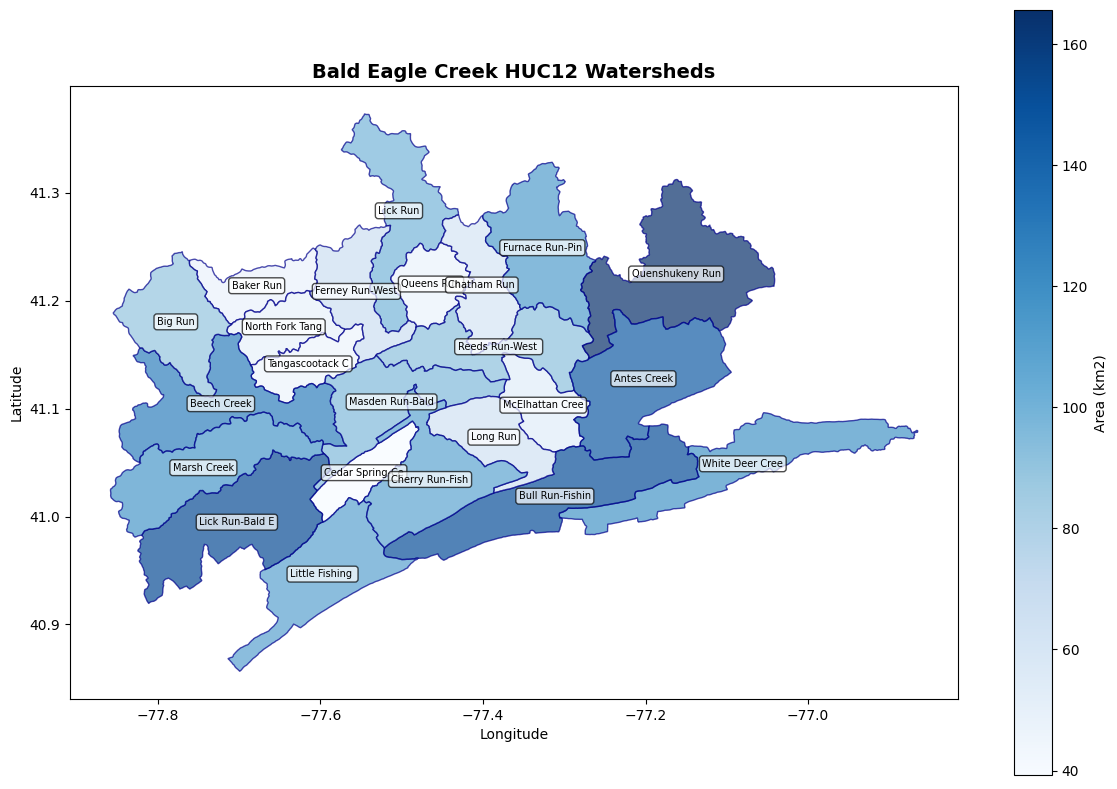

In [7]:
try:
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(12, 8))
    watersheds.plot(ax=ax, column='areasqkm', cmap='Blues', edgecolor='darkblue',
                    linewidth=1, alpha=0.7, legend=True,
                    legend_kwds={'label': 'Area (km2)'})
    
    # Label each watershed
    for idx, row in watersheds.iterrows():
        centroid = row.geometry.centroid
        ax.annotate(row['name'][:15], xy=(centroid.x, centroid.y),
                    ha='center', va='center', fontsize=7,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    ax.set_title('Bald Eagle Creek HUC12 Watersheds', fontsize=14, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("Matplotlib not available - skipping visualization")

---

## Phase 2: AORC Storm Catalog

Generate a catalog of significant storm events from AORC data. This identifies storms with the highest precipitation depths for design storm analysis.

In [8]:
# Get AORC dataset information
aorc_info = HmsAorc.get_info()
print("AORC Dataset Information:")
print(f"  Name: {aorc_info['name']}")
print(f"  Source: {aorc_info['source']}")
print(f"  Coverage: {aorc_info['coverage']['spatial']}")
print(f"  Resolution: {aorc_info['resolution']['spatial']}, {aorc_info['resolution']['temporal']}")
print(f"  Primary Variable: APCP_surface - {aorc_info['variables']['APCP_surface']}")

AORC Dataset Information:
  Name: Analysis of Record for Calibration (AORC)
  Source: s3://noaa-nws-aorc-v1-1-1km/
  Coverage: Continental US (CONUS) and Alaska
  Resolution: 30 arc-seconds (~800 meters), Hourly
  Primary Variable: APCP_surface - Hourly total precipitation (kg/m²)


In [9]:
# Generate storm catalog for 2019
# Using 2019 as a stable year with good data coverage
print("Generating storm catalog for 2019...")
print("(This may take 30-60 seconds to query AWS S3 - please wait...)")

import time
start_time = time.time()

storms = HmsAorc.get_storm_catalog(bounds, year=2019)

elapsed = time.time() - start_time
print(f"  Query completed in {elapsed:.1f} seconds")

if len(storms) > 0:
    print(f"\nFound {len(storms)} significant storm events")
    print(f"Total precipitation depth range: {storms['total_depth_in'].min():.2f} - {storms['total_depth_in'].max():.2f} inches")
else:
    print("\nNo storms found in 2019 - trying 2018 as fallback year...")
    start_time = time.time()
    storms = HmsAorc.get_storm_catalog(bounds, year=2018)
    elapsed = time.time() - start_time
    print(f"  Query completed in {elapsed:.1f} seconds")
    if len(storms) > 0:
        print(f"Found {len(storms)} significant storm events in 2018")

Generating storm catalog for 2019...
(This may take 30-60 seconds to query AWS S3 - please wait...)


2026-01-08 13:32:45 - hms_commander.HmsAorc - INFO - Generating storm catalog for 2019


2026-01-08 13:32:45 - hms_commander.HmsAorc - INFO -   Bounds: W=-77.7100, S=41.0100, E=-77.2500, N=41.2200


2026-01-08 13:32:45 - hms_commander.HmsAorc - INFO -   Parameters: inter_event=8.0h, min_depth=0.5in, buffer=48h


2026-01-08 13:32:45 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2026-01-08 13:32:45 - hms_commander.HmsAorc - INFO - Loading s3://noaa-nws-aorc-v1-1-1km/2019.zarr...


2026-01-08 13:32:47 - hms_commander.HmsAorc - INFO - Loading spatial subset...


2026-01-08 13:32:49 - hms_commander.HmsAorc - INFO - Loaded 8760 hourly timesteps


2026-01-08 13:32:50 - hms_commander.HmsAorc - INFO - Identified 135 raw events


2026-01-08 13:32:50 - hms_commander.HmsAorc - INFO - Storm catalog complete: 37 storms


2026-01-08 13:32:50 - hms_commander.HmsAorc - INFO -   Total depth range: 0.51 - 1.93 inches


2026-01-08 13:32:50 - hms_commander.HmsAorc - INFO -   Largest storm: 2019-10-31 01:00:00 (1.93 in)


  Query completed in 8.8 seconds

Found 37 significant storm events
Total precipitation depth range: 0.51 - 1.93 inches


In [10]:
# Display top 10 storms by total depth
if len(storms) > 0:
    display_cols = ['storm_id', 'start_time', 'end_time', 'duration_hours', 'total_depth_in', 'rank']
    storms[display_cols].head(10)
else:
    print("No storm data available to display")

### Storm Catalog Visualization

Generate summary visualizations of all storm events.

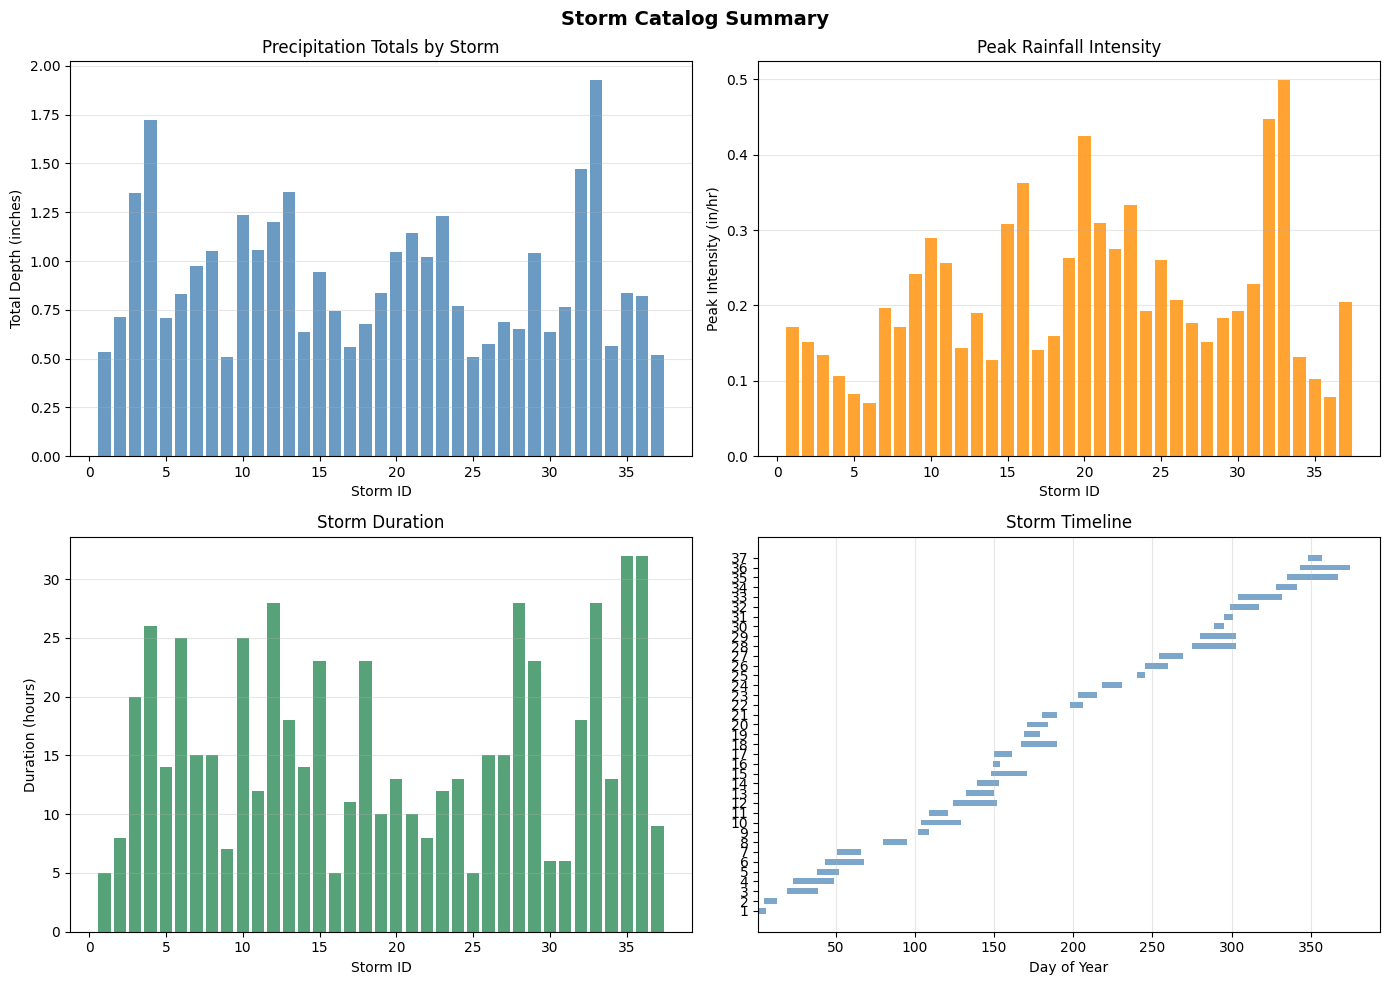

In [11]:
# Create storm catalog summary visualization
if len(storms) > 0:
    try:
        import matplotlib.pyplot as plt
        import numpy as np

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # 1. Total depth by storm
        ax1 = axes[0, 0]
        bars1 = ax1.bar(storms['storm_id'], storms['total_depth_in'], color='steelblue', alpha=0.8)
        ax1.set_xlabel('Storm ID')
        ax1.set_ylabel('Total Depth (inches)')
        ax1.set_title('Precipitation Totals by Storm')
        ax1.grid(True, alpha=0.3, axis='y')

        # 2. Peak intensity
        ax2 = axes[0, 1]
        bars2 = ax2.bar(storms['storm_id'], storms['peak_intensity_in_hr'], color='darkorange', alpha=0.8)
        ax2.set_xlabel('Storm ID')
        ax2.set_ylabel('Peak Intensity (in/hr)')
        ax2.set_title('Peak Rainfall Intensity')
        ax2.grid(True, alpha=0.3, axis='y')

        # 3. Duration
        ax3 = axes[1, 0]
        bars3 = ax3.bar(storms['storm_id'], storms['duration_hours'], color='seagreen', alpha=0.8)
        ax3.set_xlabel('Storm ID')
        ax3.set_ylabel('Duration (hours)')
        ax3.set_title('Storm Duration')
        ax3.grid(True, alpha=0.3, axis='y')

        # 4. Storm timeline
        ax4 = axes[1, 1]
        for i, (_, storm) in enumerate(storms.iterrows()):
            ax4.barh(i, storm['duration_hours'], left=storm['start_time'].dayofyear,
                     height=0.6, color='steelblue', alpha=0.7)
        ax4.set_yticks(range(len(storms)))
        ax4.set_yticklabels(storms['storm_id'])
        ax4.set_xlabel('Day of Year')
        ax4.set_title('Storm Timeline')
        ax4.grid(True, alpha=0.3, axis='x')

        plt.suptitle('Storm Catalog Summary', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

    except ImportError:
        print("Matplotlib not available - skipping visualization")
else:
    print("No storms available for visualization")

---

## Phase 3: Download AORC Data

Download AORC precipitation data for the selected (largest) storm event.

In [12]:
# Select the largest storm for demonstration
# Convert to dict for consistent access pattern throughout notebook
if len(storms) > 0:
    largest_storm_row = storms[storms['rank'] == 1].iloc[0]
    largest_storm = largest_storm_row.to_dict()

    print("Selected Storm (Largest):")
    print(f"  Storm ID: {largest_storm['storm_id']}")
    print(f"  Start: {largest_storm['start_time']}")
    print(f"  End: {largest_storm['end_time']}")
    print(f"  Duration: {largest_storm['duration_hours']} hours")
    print(f"  Total Depth: {largest_storm['total_depth_in']:.2f} inches")
    print(f"\nRecommended Simulation Window:")
    print(f"  Start: {largest_storm['sim_start']}")
    print(f"  End: {largest_storm['sim_end']}")
else:
    print("No storms available - using fixed date range for demonstration")
    # Fallback to a known good period
    largest_storm = {
        'storm_id': 'FALLBACK_2019',
        'sim_start': '2019-06-01',
        'sim_end': '2019-06-03',
        'total_depth_in': 2.0
    }

Selected Storm (Largest):
  Storm ID: 33
  Start: 2019-10-31 01:00:00
  End: 2019-11-01 04:00:00
  Duration: 28 hours
  Total Depth: 1.93 inches

Recommended Simulation Window:
  Start: 2019-10-29 01:00:00
  End: 2019-11-03 04:00:00


In [13]:
# Download AORC data for the storm
# largest_storm is now always a dict for consistent access
nc_file = output_dir / "aorc_storm.nc"

print(f"Downloading AORC data from AWS S3...")
print(f"  Bounds: {bounds}")
print(f"  Period: {largest_storm['sim_start']} to {largest_storm['sim_end']}")

nc_result = HmsAorc.download(
    bounds=bounds,
    start_time=str(largest_storm['sim_start']),
    end_time=str(largest_storm['sim_end']),
    output_path=nc_file
)

print(f"\nDownload complete!")
print(f"  File: {nc_result}")
print(f"  Size: {nc_result.stat().st_size / (1024*1024):.2f} MB")

2026-01-08 13:32:51 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2026-01-08 13:32:51 - hms_commander.HmsAorc - INFO -   Bounds: W=-77.7100, S=41.0100, E=-77.2500, N=41.2200


2026-01-08 13:32:51 - hms_commander.HmsAorc - INFO -   Time range: 2019-10-29 01:00:00 to 2019-11-03 04:00:00


2026-01-08 13:32:51 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2026-01-08 13:32:51 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2026-01-08 13:32:51 - hms_commander.HmsAorc - INFO -   Loading year 2019 from s3://noaa-nws-aorc-v1-1-1km/2019.zarr


  Bounds: (-77.71, 41.01, -77.25, 41.22)
  Period: 2019-10-29 01:00:00 to 2019-11-03 04:00:00


2026-01-08 13:32:51 - hms_commander.HmsAorc - INFO -     Loaded Frozen({'time': 144, 'latitude': 25, 'longitude': 55})


2026-01-08 13:32:51 - hms_commander.HmsAorc - INFO - Combining datasets...


2026-01-08 13:32:51 - hms_commander.HmsAorc - INFO - Writing to NetCDF: aorc_workflow_output\aorc_storm.nc


2026-01-08 13:32:51 - hms_commander.HmsAorc - INFO - Download complete: aorc_workflow_output\aorc_storm.nc (0.4 MB)



Download complete!
  File: aorc_workflow_output\aorc_storm.nc
  Size: 0.40 MB


In [14]:
# Examine the NetCDF file structure
try:
    import xarray as xr
    
    ds = xr.open_dataset(nc_file)
    print("NetCDF Structure:")
    print(ds)
    
    # Get grid dimensions
    lon_dim = 'longitude' if 'longitude' in ds.dims else 'lon' if 'lon' in ds.dims else 'x'
    lat_dim = 'latitude' if 'latitude' in ds.dims else 'lat' if 'lat' in ds.dims else 'y'
    time_dim = 'time' if 'time' in ds.dims else 'valid_time'
    
    print(f"\nGrid Dimensions:")
    print(f"  Longitude: {len(ds[lon_dim])} cells ({float(ds[lon_dim].min()):.4f}deg to {float(ds[lon_dim].max()):.4f}deg)")
    print(f"  Latitude: {len(ds[lat_dim])} cells ({float(ds[lat_dim].min()):.4f}deg to {float(ds[lat_dim].max()):.4f}deg)")
    print(f"  Time: {len(ds[time_dim])} timesteps")
    
    ds.close()
except Exception as e:
    print(f"Could not examine NetCDF: {e}")

NetCDF Structure:
<xarray.Dataset> Size: 2MB
Dimensions:       (time: 144, latitude: 25, longitude: 55)
Coordinates:
  * time          (time) datetime64[ns] 1kB 2019-10-29 ... 2019-11-03T23:00:00
  * latitude      (latitude) float64 200B 41.02 41.02 41.03 ... 41.2 41.21 41.22
  * longitude     (longitude) float64 440B -77.7 -77.69 -77.69 ... -77.26 -77.25
Data variables:
    APCP_surface  (time, latitude, longitude) float64 2MB ...

Grid Dimensions:
  Longitude: 55 cells (-77.7021deg to -77.2521deg)
  Latitude: 25 cells (41.0158deg to 41.2158deg)
  Time: 144 timesteps


---

## Phase 4: Convert to DSS Grid

Convert the NetCDF to HMS-compatible DSS grid format using HEC Monolith libraries.

In [15]:
# Convert NetCDF to DSS grid
dss_file = output_dir / "aorc_storm.dss"

print("Converting to DSS grid format...")
print("(Using HEC Monolith via pyjnius)")

dss_result = HmsAorc.convert_to_dss_grid(
    netcdf_file=nc_file,
    output_dss_file=dss_file,
    pathname="/AORC/BALDEAGLE/PRECIP////",
    units="MM"
)

print(f"\nConversion complete!")
print(f"  File: {dss_result}")
print(f"  Size: {dss_result.stat().st_size / (1024*1024):.2f} MB")

2026-01-08 13:32:51 - hms_commander.HmsAorc - INFO - Converting AORC NetCDF to DSS grid:


2026-01-08 13:32:51 - hms_commander.HmsAorc - INFO -   Input: aorc_workflow_output\aorc_storm.nc


2026-01-08 13:32:51 - hms_commander.HmsAorc - INFO -   Output: aorc_workflow_output\aorc_storm.dss


2026-01-08 13:32:51 - hms_commander.HmsAorc - INFO -   Pathname: /AORC/BALDEAGLE/PRECIP////


2026-01-08 13:32:51 - hms_commander.HmsAorc - INFO -   Grid shape: (144, 25, 55) (time, lat, lon)


2026-01-08 13:32:51 - hms_commander.HmsAorc - INFO -   Time range: 2019-10-29 00:00:00 to 2019-11-03 23:00:00


2026-01-08 13:32:51 - hms_commander.HmsAorc - INFO -   Lat range: 41.0158 to 41.2158


2026-01-08 13:32:51 - hms_commander.HmsAorc - INFO -   Lon range: -77.7021 to -77.2521


2026-01-08 13:32:51 - hms_commander.dss.hms_dss_grid - INFO - Configuring HEC Monolith for DSS grid writing...


2026-01-08 13:32:51 - hms_commander.dss.core - INFO - Configured JVM with max memory: 4G


Converting to DSS grid format...
(Using HEC Monolith via pyjnius)
Configuring Java VM for DSS operations...
  Found Java: C:\Program Files\Java\jre1.8.0_471
[OK] Java VM configured


2026-01-08 13:32:52 - hms_commander.dss.hms_dss_grid - INFO - Writing DSS grid to: aorc_workflow_output\aorc_storm.dss


2026-01-08 13:32:52 - hms_commander.dss.hms_dss_grid - INFO -   Pathname: /AORC/BALDEAGLE/PRECIP////


2026-01-08 13:32:52 - hms_commander.dss.hms_dss_grid - INFO -   Grid: 25 lat x 55 lon = 1375 cells


2026-01-08 13:32:52 - hms_commander.dss.hms_dss_grid - INFO -   Timesteps: 144


2026-01-08 13:32:52 - hms_commander.dss.hms_dss_grid - INFO -   Cell size: 0.008333 degrees


2026-01-08 13:32:52 - hms_commander.dss.hms_dss_grid - INFO -   Origin: (-77.7021, 41.0158)


2026-01-08 13:32:52 - hms_commander.dss.hms_dss_grid - INFO -   Units: MM, Type: PER-CUM


2026-01-08 13:32:52 - hms_commander.dss.hms_dss_grid - INFO -   Wrote 10/144 timesteps


2026-01-08 13:32:52 - hms_commander.dss.hms_dss_grid - INFO -   Wrote 20/144 timesteps


2026-01-08 13:32:52 - hms_commander.dss.hms_dss_grid - INFO -   Wrote 30/144 timesteps


2026-01-08 13:32:52 - hms_commander.dss.hms_dss_grid - INFO -   Wrote 40/144 timesteps


2026-01-08 13:32:52 - hms_commander.dss.hms_dss_grid - INFO -   Wrote 50/144 timesteps


2026-01-08 13:32:52 - hms_commander.dss.hms_dss_grid - INFO -   Wrote 60/144 timesteps


2026-01-08 13:32:52 - hms_commander.dss.hms_dss_grid - INFO -   Wrote 70/144 timesteps


2026-01-08 13:32:52 - hms_commander.dss.hms_dss_grid - INFO -   Wrote 80/144 timesteps


2026-01-08 13:32:52 - hms_commander.dss.hms_dss_grid - INFO -   Wrote 90/144 timesteps


2026-01-08 13:32:52 - hms_commander.dss.hms_dss_grid - INFO -   Wrote 100/144 timesteps


2026-01-08 13:32:52 - hms_commander.dss.hms_dss_grid - INFO -   Wrote 110/144 timesteps


2026-01-08 13:32:52 - hms_commander.dss.hms_dss_grid - INFO -   Wrote 120/144 timesteps


2026-01-08 13:32:52 - hms_commander.dss.hms_dss_grid - INFO -   Wrote 130/144 timesteps


2026-01-08 13:32:52 - hms_commander.dss.hms_dss_grid - INFO -   Wrote 140/144 timesteps


2026-01-08 13:32:52 - hms_commander.dss.hms_dss_grid - INFO -   Wrote 144/144 timesteps


2026-01-08 13:32:52 - hms_commander.dss.hms_dss_grid - INFO - DSS grid write complete: aorc_workflow_output\aorc_storm.dss


2026-01-08 13:32:52 - hms_commander.dss.hms_dss_grid - INFO -   File size: 0.38 MB


2026-01-08 13:32:52 - hms_commander.dss.hms_dss_grid - INFO -   Total cells: 198,000


2026-01-08 13:32:52 - hms_commander.HmsAorc - INFO - DSS conversion complete: aorc_workflow_output\aorc_storm.dss



Conversion complete!
  File: aorc_workflow_output\aorc_storm.dss
  Size: 0.38 MB


In [16]:
# Verify DSS file (optional - requires ras-commander DSS support)
try:
    from ras_commander.dss import RasDss
    
    catalog = RasDss.get_catalog(str(dss_file))
    print(f"DSS Catalog: {len(catalog)} records")
    print(f"\nSample pathnames:")
    for path in catalog[:5]:
        print(f"  {path}")
    if len(catalog) > 5:
        print(f"  ... and {len(catalog) - 5} more")
except Exception as e:
    print(f"Could not read DSS catalog: {e}")
    print("(This is normal if ras-commander is not installed)")

DSS Catalog: 144 records

Sample pathnames:
  pathname
  ... and 139 more


---

## Summary

This notebook demonstrated:
1. Downloading HUC12 watershed boundaries using HmsHuc
2. Generating storm catalogs from AORC data using HmsAorc
3. Downloading AORC precipitation data for a selected storm
4. Converting to DSS grid format for HMS

**Output Files Created**:
- `aorc_storm.nc` - NetCDF precipitation data
- `aorc_storm.dss` - DSS grid for HMS

**Next Steps**:
- Continue to **14b_aorc_grid_setup.ipynb** to create HMS grid definition and cell mapping files

In [17]:
# Summary of outputs
print("=" * 60)
print("PHASE 1-2 COMPLETE: AORC DOWNLOAD")
print("=" * 60)

print(f"\nStudy Area: Bald Eagle Creek, PA")
print(f"  Bounds: {bounds}")
print(f"  HUC12 watersheds: {len(watersheds)}")
print(f"  Total area: {watersheds['areasqkm'].sum():.1f} km2")

if len(storms) > 0:
    # largest_storm is always a dict now
    print(f"\nSelected Storm:")
    print(f"  Total depth: {largest_storm['total_depth_in']:.2f} inches")

print(f"\nOutput Files:")
for f in sorted(output_dir.glob("*")):
    if f.is_file():
        print(f"  {f.name}: {f.stat().st_size / 1024:.1f} KB")

print(f"\nWorkflow completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("\n--> Continue to 14b_aorc_grid_setup.ipynb")

PHASE 1-2 COMPLETE: AORC DOWNLOAD

Study Area: Bald Eagle Creek, PA
  Bounds: (-77.71, 41.01, -77.25, 41.22)
  HUC12 watersheds: 23
  Total area: 2150.5 km2

Selected Storm:
  Total depth: 1.93 inches

Output Files:
  aorc.grid: 0.5 KB
  aorc_storm.dss: 389.9 KB
  aorc_storm.nc: 405.2 KB
  hrapcells: 11.8 KB

Workflow completed: 2026-01-08 13:32:53

--> Continue to 14b_aorc_grid_setup.ipynb
